# Taxon definition and lineage

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import toytree
import toyplot
import scipy.stats as sc

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from paraspec.base import IR12SpeciationModel, DD03SpeciationModel
from paraspec.fastscape_ext import FastscapeElevationTrait

## Functions to compute and visualize speciation model

In [2]:
def run_model(trait_comp=False, num_gen=250, pop_size = 10, dt=1,
             sigma_env_trait=0.3, mut_prob=0.05, sigma_mut=0.05, sigma_mov=5,
             random_seed=1234, distance_value=1.0):
    length = (250, 250)
    spacing = (1, 1)
    X, Y = np.meshgrid(*[np.arange(0, l + s, s) for l, s in zip(length, spacing)])
    r = np.random.RandomState(0)
    environment = X + r.rand(*Y.shape)
    trait_01_elev = FastscapeElevationTrait(topo_elevation=environment,
                                        init_trait_min=0.5,
                                        init_trait_max=0.5,
                                        lin_slope=0.95, 
                                        norm_min=environment.min(), 
                                        norm_max=environment.max(), 
                                        random_seed=1234)
    trait_01_elev.initialize()
    init_trait_funcs =  {
    'trait_1': trait_01_elev.init_trait_func,
    }
    opt_trait_funcs = {
    'trait_1': trait_01_elev.opt_trait_func
    }
    
    if trait_comp:
        model = DD03SpeciationModel(X, Y, init_trait_funcs, opt_trait_funcs, pop_size,
                                    car_cap_max=250, sigma_env_trait=sigma_env_trait, mut_prob=mut_prob, 
                                    sigma_mut=sigma_mut, sigma_mov=sigma_mov, sigma_comp_trait=sigma_env_trait, 
                                    sigma_comp_dist=sigma_env_trait, random_seed=random_seed, 
                                    distance_value=distance_value)
    else:
        model = IR12SpeciationModel(X, Y, init_trait_funcs, opt_trait_funcs, pop_size, 
                                    nb_radius=50, car_cap=25, sigma_env_trait=sigma_env_trait, mut_prob=mut_prob, 
                                    sigma_mut=sigma_mut, sigma_mov=sigma_mov, random_seed=random_seed, 
                                    distance_value=distance_value)

    model.initialize()
    dfs = []
    for step in range(num_gen):
        model.evaluate_fitness(dt)
        dfs.append(model.to_dataframe())
        model.update_individuals(dt)
    return pd.concat(dfs).reset_index(drop=True), environment, X

In [3]:
def plot_sol(dtf, elevation, X):
    num_gen = dtf.step.unique().size
    fig1, axs1 = plt.subplots(2, 2, sharex="col", figsize=(12, 6))
    axs1[0,0].plot(dtf.groupby('step').size())
    h,xedge,yedge,_=axs1[1,0].hist2d(x=dtf['step'], y=dtf['trait_0'],
                                     range=((0, num_gen), (0, 1)),
                                     bins=(num_gen, 100), cmap='bone_r')
    axs1[0, 1].pcolormesh(elevation)
    axs1[0, 1].scatter(dtf['x'].loc[dtf['step']==max(dtf['step'])],
                       dtf['y'].loc[dtf['step']==max(dtf['step'])],
                       c=dtf['trait_0'].loc[dtf['step']==max(dtf['step'])],
                       edgecolor='w',vmin=0, vmax=1)
    h,xedge,yedge,_=axs1[1,1].hist2d(x=dtf['x'].loc[dtf['step']==max(dtf['step'])],
                                     y=dtf['trait_0'].loc[dtf['step']==max(dtf['step'])],
                                     range=((0, X.max()), (0, 1)),
                                     bins=(25, 250), cmap='bone_r')
    axs1[0, 1].yaxis.set_label_position("right")
    axs1[0, 1].yaxis.tick_right()
    axs1[1, 1].yaxis.set_label_position("right")
    axs1[1, 1].yaxis.tick_right()
    axs1[0, 1].set_ylabel('Y', weight='bold')
    axs1[0, 0].set_ylabel('Abundance (No. ind)', weight='bold')
    axs1[1, 1].set_ylabel('Trait', weight='bold')
    axs1[1, 0].set_ylabel('Trait', weight='bold')
    axs1[1, 1].set_xlabel('X', weight='bold')
    axs1[1, 0].set_xlabel('Time (generations)', weight='bold')

In [4]:
def toytree_plot(tree, ind_dtf):
    """
    Plot of phylogenetic tree using library toytree and following the cookbook example 
    https://toytree.readthedocs.io/en/latest/
    
    Parameters
    ----------
    tree : class 'dendropy.tree'
        Phylogenetic tree as class dendropy.tree
    ind_dtf : class 'pandas.DataFrame'
        Speciation model output with data for all individuals
        
    """
    ttree = toytree.tree(tree.as_string(schema='newick'))
    # generate a distribution between 0 and 1 for each tip in the tree
    points = np.linspace(0, 1, 50)
    dists = {}
    for tip in ttree.get_tip_labels():
        trait_values = ind_dtf[ind_dtf.taxon_id==int(tip)].trait_0.values
        if trait_values.size > 1:
            kernel = sc.gaussian_kde(trait_values)                                 
            dists[tip] = kernel(points)
        else:
            dists[tip] = None
    # set up canvas for two panel plot
    canvas = toyplot.Canvas(width=300, height=400)

    # add tree to canvas
    ax0 = canvas.cartesian(bounds=(50, 180, 50, 350), ymin=0, ymax=ttree.ntips, padding=15)
    ttree.draw(axes=ax0, tip_labels=False)
    ax0.show = False

    # add histograms to canvas
    ax1 = canvas.cartesian(bounds=(200, 275, 50, 350), ymin=0, ymax=ttree.ntips, padding=15)

    # iterate from top to bottom (ntips to 0)
    for tip in range(ttree.ntips)[::-1]:

        # select a color for hist
        color = toytree.colors[int((tip) / 10)]

        # get tip name and get hist from dict
        tipname = ttree.get_tip_labels()[tip]
        probs = dists[tipname]
        
        if probs is not None:
            
            # fill histogram with slightly overlapping histograms
            ax1.fill(
                points, probs / probs.max() * 1.25,
                baseline=[tip] * len(points),
                style={"fill": color, "stroke": "white", "stroke-width": 0.5},
                title=tipname,
            )
            # add horizontal line at base
            ax1.hlines(tip, opacity=0.5, color="grey", style={"stroke-width": 0.5})

    # hide y axis, show x
    ax1.y.show = False
    ax1.x.label.text = "Trait value"
    ax1.x.ticks.show = True

## Phylogeny for the speciation model without trait-mediated competition

In [5]:
ind_dtf1, elevation1, X1 = run_model(trait_comp=False)

In [6]:
ind_dtf1

,step,time,dt,x,y,taxon_id,ancestor_id,n_offspring,fitness,trait_0
0,0,0.0,0.0,244.174942,110.251531,1,0,8,0.321987,0.500000
1,0,0.0,0.0,95.048934,152.467702,1,0,8,0.932487,0.500000
2,0,0.0,0.0,230.811558,215.905324,1,0,10,0.405734,0.500000
3,0,0.0,0.0,65.423106,215.939418,1,0,5,0.751070,0.500000
4,0,0.0,0.0,79.774265,168.720328,1,0,5,0.853670,0.500000
...,...,...,...,...,...,...,...,...,...,...
59867,249,249.0,0.0,51.797094,64.897784,1129,1122,1,0.987641,0.269166
59868,249,249.0,0.0,90.076479,87.894864,1129,1122,1,0.885399,0.218630
59869,249,249.0,0.0,97.986734,146.885239,1130,1123,1,0.947714,0.298053
59870,249,249.0,0.0,90.409237,247.510531,1131,1124,1,0.974239,0.435360


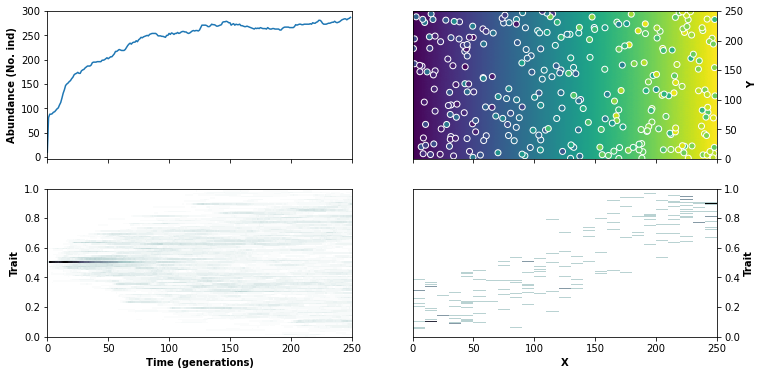

In [7]:
plot_sol(ind_dtf1, elevation1, X1)

In [8]:
taxon_lineage1 = ind_dtf1.ptree.extract_taxon_summary()
taxon_lineage1

,time,taxon_id,ancestor_id,trait_0,abundance,node_type
0,0.0,1,0,0.500000,10,root
1,1.0,2,1,0.499899,81,node
2,2.0,3,2,0.499440,88,node
3,3.0,4,3,0.497699,88,node
4,4.0,5,4,0.497136,89,node
...,...,...,...,...,...,...
1130,249.0,1131,1124,0.390151,28,leaf
1131,249.0,1132,1125,0.491048,21,leaf
1132,249.0,1133,1126,0.778635,21,leaf
1133,249.0,1134,1127,0.682153,42,leaf


In [9]:
tree1 = ind_dtf1.ptree.to_dendropy_tree()
toytree_plot(tree1, ind_dtf1)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="300.0px" height="400.0px" viewBox="0 0 300.0 400.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="ta64865a8a47c425c9b046901c9445b66"> <polygon points="200.0,92.85714285714286 201.53061224489795,92.85714285714286 203.0612244897959,92.85714285714286 204.59183673469389,92.85714285714286 206.12244897959187,92.85714285714286 207.6530612244898,92.85714285714286 209.18367346938774,92.85714285714286 210.71428571428572,92.85714285714286 212.24489795918367,92.85714285714286 213.77551020408163,92.85714285714286 215.30612244897958,92.85714285714286 216.83673469387753,92.85714285714286 218.36734693877548,92.85714285714286 219.8979591836735,92.85714285714286 221.42857142857144,92.85714285714286 222.9591836734694,92.85714285714286 224.48979591836735,92.85714285714286 226.0204081632653,92.85714285714286 227.55102040816325,92.85714285714286 229.0816326530612,92.85714285714286 230.61224489795916,92.85714285714286 232.1428571428571,92.85714285714286 233.6734693877551,92.85714285714286 235.20408163265304,92.85714285714286 236.73469387755102,92.85714285714286 238.26530612244898,92.85714285714286 239.79591836734693,92.85714285714286 241.3265306122449,92.85714285714286 242.85714285714286,92.85714285714286 244.3877551020408,92.85714285714286 245.91836734693877,92.85714285714286 247.44897959183675,92.85714285714286 248.9795918367347,92.85714285714286 250.51020408163265,92.85714285714286 252.0408163265306,92.85714285714286 253.57142857142858,92.85714285714286 255.10204081632654,92.85714285714286 256.6326530612245,92.85714285714286 258.16326530612247,92.85714285714286 259.6938775510204,92.85714285714286 261.2244897959184,92.85714285714286 262.7551020408163,92.85714285714286 264.2857142857143,92.85714285714286 265.81632653061223,92.85714285714286 267.3469387755102,92.85714285714286 268.8775510204082,92.85714285714286 270.4081632653061,92.85714285714286 271.9387755102041,92.85714285714286 273.469387755102,92.85714285714286 275.0,92.85714285714286 275.0,92.80503635231234 273.469387755102,92.68479172336406 271.9387755102041,92.37050146733313 270.4081632653061,91.6730926290889 268.8775510204082,90.34137294435513 267.3469387755102,88.10519323359836 265.81632653061223,84.70424782096589 264.2857142857143,79.88322103515014 262.7551020408163,73.44918074640155 261.2244897959184,65.5220475522029 259.6938775510204,56.86031387892133 258.16326530612247,48.835781406329204 256.6326530612245,42.8443504803453 255.10204081632654,39.6415171951414 253.57142857142858,39.285714285714256 252.0408163265306,41.59098191666211 250.51020408163265,46.33671877130598 248.9795918367347,52.95674168853933 247.44897959183675,60.24870899181102 245.91836734693877,66.62143716156555 244.3877551020408,70.78039645439392 242.85714285714286,72.40361546331104 241.3265306122449,72.37453418217996 239.79591836734693,72.30936564622573 238.26530612244898,73.5674024880901 236.73469387755102,76.46282912007976 235.20408163265304,80.30508406358135 233.6734693877551,84.10607610048933 232.1428571428571,87.22401460453534 230.61224489795916,89.49413620813579 229.0816326530612,91.01552167406572 227.55102040816325,91.95217775174507 226.0204081632653,92.46733018331845 224.48979591836735,92.71267848201754 222.9591836734694,92.81165973517457 221.42857142857144,92.84507228502568 219.8979591836735,92.8544550665319 218.36734693877548,92.85664200863204 216.83673469387753,92.8570648723225 215.30612244897958,92.85713271945808 213.77551020408163,92.85714175741617 212.24489795918367,92.85714275761825 210.71428571428572,92.85714284962995 209.18367346938774,92.85714285666981 207.6530612244898,92.85714285711799 206.122448

## Tree summary statistics 

Phylogenetic diversity (PD)

In [10]:
sum(tree1.calc_node_root_distances())

1743.0

In [11]:
pdm1=tree1.phylogenetic_distance_matrix()

Mean pairwise distance (MPD)

In [12]:
pdm1.mean_pairwise_distance()

378.1904761904762

Mean neighbor taxon distance (MNTD)

In [13]:
pdm1.mean_nearest_taxon_distance()

227.14285714285714

Lineages through time (LTT)

Text(0, 0.5, 'Number of Lineages')

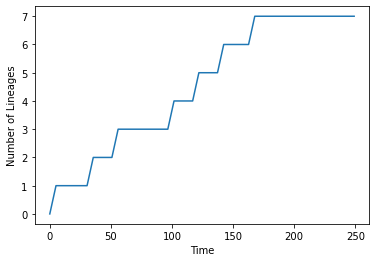

In [14]:
time_steps1 = np.linspace(0, tree1.max_distance_from_root(), 50)
ltt1=[tree1.num_lineages_at(t) for t in time_steps1]
plt.plot(time_steps1, ltt1)
plt.xlabel('Time')
plt.ylabel('Number of Lineages')

## Phylogeny for the speciation model with trait-mediated competition

In [15]:
ind_dtf2, elevation2, X2 = run_model(trait_comp=True)

In [16]:
ind_dtf2

,step,time,dt,x,y,taxon_id,ancestor_id,n_offspring,events_i,death_i,trait_0
0,0,0.0,0.0,244.174942,110.251531,1,0,2,B,0.069492,0.500000
1,0,0.0,0.0,95.048934,152.467702,1,0,1,M,0.063454,0.500000
2,0,0.0,0.0,230.811558,215.905324,1,0,1,M,0.059319,0.500000
3,0,0.0,0.0,65.423106,215.939418,1,0,1,M,0.068145,0.500000
4,0,0.0,0.0,79.774265,168.720328,1,0,2,B,0.067284,0.500000
...,...,...,...,...,...,...,...,...,...,...,...
51262,249,249.0,1.0,183.819875,17.546232,548,543,1,M,1.403912,0.549816
51263,249,249.0,1.0,148.932553,41.356403,548,543,1,M,1.401643,0.633978
51264,249,249.0,1.0,149.886743,73.645842,548,543,1,M,1.432503,0.633978
51265,249,249.0,1.0,183.114311,19.377967,548,543,0,D,1.404063,0.549816


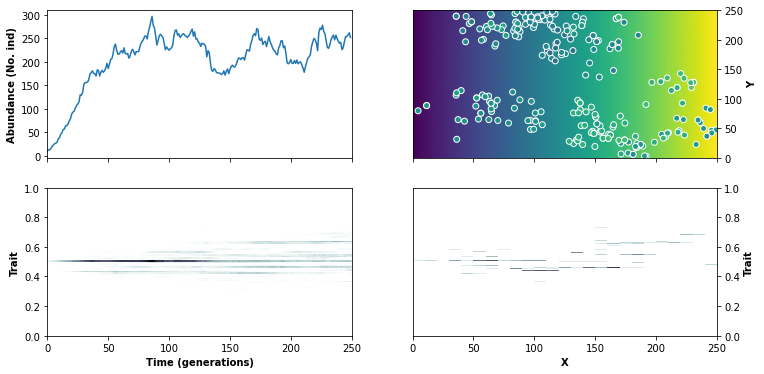

In [17]:
plot_sol(ind_dtf2, elevation2, X2)

In [18]:
taxon_lineage2 = ind_dtf2.ptree.extract_taxon_summary()
taxon_lineage2

,time,taxon_id,ancestor_id,trait_0,abundance,node_type
0,0.0,1,0,0.500000,10,root
1,1.0,2,1,0.500000,13,node
2,2.0,3,2,0.500000,13,node
3,3.0,4,3,0.500000,16,node
4,4.0,5,4,0.500000,20,node
...,...,...,...,...,...,...
544,249.0,545,539,0.518894,66,leaf
545,249.0,546,540,0.566679,14,leaf
546,249.0,547,541,0.530616,47,leaf
547,249.0,548,543,0.523690,52,leaf


In [19]:
tree2 = ind_dtf2.ptree.to_dendropy_tree()
toytree_plot(tree2, ind_dtf2)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="300.0px" height="400.0px" viewBox="0 0 300.0 400.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t6c692b8ab3cd426486403f80344c38b3"> <polygon points="200.0,100.0 201.53061224489795,100.0 203.0612244897959,100.0 204.59183673469389,100.0 206.12244897959187,100.0 207.6530612244898,100.0 209.18367346938774,100.0 210.71428571428572,100.0 212.24489795918367,100.0 213.77551020408163,100.0 215.30612244897958,100.0 216.83673469387753,100.0 218.36734693877548,100.0 219.8979591836735,100.0 221.42857142857144,100.0 222.9591836734694,100.0 224.48979591836735,100.0 226.0204081632653,100.0 227.55102040816325,100.0 229.0816326530612,100.0 230.61224489795916,100.0 232.1428571428571,100.0 233.6734693877551,100.0 235.20408163265304,100.0 236.73469387755102,100.0 238.26530612244898,100.0 239.79591836734693,100.0 241.3265306122449,100.0 242.85714285714286,100.0 244.3877551020408,100.0 245.91836734693877,100.0 247.44897959183675,100.0 248.9795918367347,100.0 250.51020408163265,100.0 252.0408163265306,100.0 253.57142857142858,100.0 255.10204081632654,100.0 256.6326530612245,100.0 258.16326530612247,100.0 259.6938775510204,100.0 261.2244897959184,100.0 262.7551020408163,100.0 264.2857142857143,100.0 265.81632653061223,100.0 267.3469387755102,100.0 268.8775510204082,100.0 270.4081632653061,100.0 271.9387755102041,100.0 273.469387755102,100.0 275.0,100.0 275.0,100.0 273.469387755102,100.0 271.9387755102041,99.99999999999939 270.4081632653061,99.99999999995148 268.8775510204082,99.99999999733186 267.3469387755102,99.99999989621125 265.81632653061223,99.99999714456968 264.2857142857143,99.9999444329411 262.7551020408163,99.99923490791483 261.2244897959184,99.9925406220448 259.6938775510204,99.94839255146792 258.16326530612247,99.74517680487048 256.6326530612245,99.0883966281889 255.10204081632654,97.54996045244823 253.57142857142858,94.68469331344588 252.0408163265306,89.82008653509214 250.51020408163265,82.28420878406587 248.9795918367347,73.6031396492969 247.44897959183675,68.27756633095287 245.91836734693877,68.52076267375001 244.3877551020408,70.12546969440695 242.85714285714286,67.86430900159228 241.3265306122449,61.78826295080545 239.79591836734693,54.7282712932896 238.26530612244898,47.60314744042928 236.73469387755102,40.771981204885435 235.20408163265304,37.49999999999998 233.6734693877551,42.17432588977233 232.1428571428571,54.837758740567956 230.61224489795916,70.17508321230306 229.0816326530612,82.56384572296452 227.55102040816325,90.31135109991301 226.0204081632653,94.80298982463943 224.48979591836735,97.52784767151127 222.9591836734694,99.06265366567061 221.42857142857144,99.73502085310639 219.8979591836735,99.94586107092618 218.36734693877548,99.99210824447339 216.83673469387753,99.99918354162348 215.30612244897958,99.99994017594315 213.77551020408163,99.99999689810119 212.24489795918367,99.99999988622747 210.71428571428572,99.99999999704849 209.18367346938774,99.99999999994586 207.6530612244898,99.99999999999929 206.12244897959187,100.0 204.59183673469389,100.0 203.0612244897959,100.0 201.53061224489795,100.0 200.0,100.0" style="fill:rgb(40%,76.1%,64.7%);fill-opacity:1.0;opacity:1.0;stroke:rgb(100%,100%,100%);stroke-opacity:1.0;stroke-width:0.5"> 545 <polygon points="200.0,150.0 201.53061224489795,150.0 203.0612244897959,150.0 204.59183673469389,150.0 206.12244897959187,150.0 207.6530612244898,150.0 209.18367346938774,150.0 210.71428571428572,150.0 212.24489795918367,150.0 213.77551020408163,150.0 215.30612244897958,150.0 216.83673469387753,150.0 218.36734693877548,150.0 219.8979591836735,150.0 221.42857142857144,150.0 222.959183673

## Tree summary statistics 

Phylogenetic diversity (PD)

In [20]:
sum(tree2.calc_node_root_distances())

1494.0

In [21]:
pdm2=tree2.phylogenetic_distance_matrix()

Mean pairwise distance (MPD)

In [22]:
pdm2.mean_pairwise_distance()

147.46666666666667

Mean neighbor taxon distance (MNTD)

In [23]:
pdm2.mean_nearest_taxon_distance()

104.66666666666667

Lineages through time (LTT)

Text(0, 0.5, 'Number of Lineages')

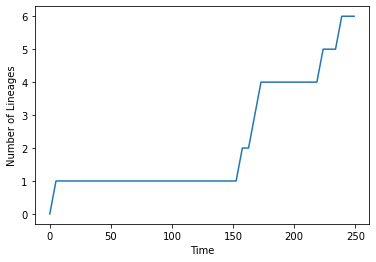

In [24]:
time_steps2 = np.linspace(0, tree2.max_distance_from_root(), 50)
ltt2 = [tree2.num_lineages_at(t) for t in time_steps2]
plt.plot(time_steps2, ltt2)
plt.xlabel('Time')
plt.ylabel('Number of Lineages')